In [36]:
import pandas as pd
import numpy as np
import sys
import matplotlib
import scipy as sp
import sklearn
import itertools

import random
import time

#Common Model Helpers
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score,precision_score,f1_score,classification_report

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df = pd.read_csv('/content/drive/MyDrive/iris.csv')

In [39]:
data = df

In [40]:
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [41]:
data["variety"].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [42]:
data.describe()

,sepal.length,sepal.width,petal.length,petal.width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [43]:
data.isna().sum()

sepal.length    0
sepal.width     0
petal.length    0
petal.width     0
variety         0
dtype: int64

In [44]:
main = data.drop(["variety"], axis=1).values
y2 = data["variety"]

In [45]:
def euclidean_distance(X, Y):
    return np.sqrt(np.sum(np.power(X - Y, 2), axis=1))

In [46]:
num_clusters = 3
feature_vector_length = main.shape[1]

In [47]:
def cluster_data(solution, solution_idx):
    global num_clusters, feature_vector_length, main
    cluster_centers = []
    all_clusters_dists = []
    clusters = []
    clusters_sum_dist = []

    for clust_idx in range(num_clusters):
        cluster_centers.append(solution[feature_vector_length*clust_idx:feature_vector_length*(clust_idx+1)])
        cluster_center_dists = euclidean_distance(main, cluster_centers[clust_idx])
        all_clusters_dists.append(np.array(cluster_center_dists))

    cluster_centers = np.array(cluster_centers)
    all_clusters_dists = np.array(all_clusters_dists)

    cluster_indices = np.argmin(all_clusters_dists, axis=0)
    for clust_idx in range(num_clusters):
        clusters.append(np.where(cluster_indices == clust_idx)[0])
        if len(clusters[clust_idx]) == 0:
            clusters_sum_dist.append(0)
        else:
            clusters_sum_dist.append(np.sum(all_clusters_dists[clust_idx, clusters[clust_idx]]))

    clusters_sum_dist = np.array(clusters_sum_dist)

    return cluster_centers, all_clusters_dists, cluster_indices, clusters, clusters_sum_dist

In [48]:
def fitness_func(i, solution, solution_idx):
    _, _, _, _, clusters_sum_dist = cluster_data(solution, solution_idx)

    fitness = 1.0 / (np.sum(clusters_sum_dist) + 0.00000001)

    return fitness

In [49]:
ranges = df.apply(lambda x: (x.min(), x.max()))

In [50]:
print(ranges)

   sepal.length  sepal.width  petal.length  petal.width    variety
0           4.3          2.0           1.0          0.1     Setosa
1           7.9          4.4           6.9          2.5  Virginica


In [51]:
min_sl = df['sepal.length'].min()
max_sl = df['sepal.length'].max()

In [52]:
min_sw = df['sepal.width'].min()
max_sw = df['sepal.width'].max()

In [53]:
min_pl = df['petal.length'].min()
max_pl = df['petal.length'].max()

In [54]:
min_pw = df['petal.width'].min()
max_pw = df['petal.width'].max()

In [55]:
class Genetic:
  def __init__(self, population_, generation, mutation_prob):

    self.population_num = population_
    self.generation = generation
    self.mutation_prob = mutation_prob
    self.chromosomes = []
    self.fitnesses = []

  def population(self):

    for i in range(self.population_num):

      a = []

      for j in range(0, 3):
        random_sl = random.uniform(min_sl, max_sl)
        a.append(random_sl)

        random_sw = random.uniform(min_sw, max_sw)
        a.append(random_sw)

        random_pl = random.uniform(min_pl, max_pl)
        a.append(random_pl)

        random_pw = random.uniform(min_pw, max_pw)
        a.append(random_pw)

      self.chromosomes.append(a)
      self.fitnesses.append(fitness_func(0, a, 0))

  def selection(self):

    s1 = []
    max = 0

    # highest fitness
    for i in range(len(self.chromosomes)):
      if fitness_func(0, self.chromosomes[i], 0) > max:
        max = fitness_func(0, self.chromosomes[i], 0)
        s1 = self.chromosomes[i]

    # random
    s2_index = np.random.randint(len(self.chromosomes))
    s2 = self.chromosomes[s2_index]

    return s1, s2

  def crossover(self, s1, s2):
    # One Point Crossover
    crossover_point1 = random.randint(0, len(s1) - 1)

    child1 = s1[:crossover_point1] + s2[crossover_point1:]

    # Multi Point Crossover
    crossover_point2 = random.randint(0, len(s1) - 1)
    crossover_point3 = random.randint(0, len(s1) - 1)

    child2 = s1[:crossover_point2] + s2[crossover_point2:crossover_point3] + s1[crossover_point3:]

    # Uniform Crossover
    size = len(s1)
    child3 = []

    for i in range(size):
      if random.random() < 0.6:
        child3.append(s1[i])
      else:
        child3.append(s2[i])

    fit1 = fitness_func(0, child1, 0)
    fit2 = fitness_func(0, child2, 0)
    fit3 = fitness_func(0, child3, 0)

    max_fit = max(fit1, fit2, fit3)

    if max_fit == fit1:
      child = child1
    elif max_fit == fit2:
      child = child2
    else:
      child = child3

    return child

  def mutation(self, s1):

    sl_array = [0, 4, 8]
    sw_array = [1, 5, 9]
    pl_array = [2, 6, 10]
    pw_array = [3, 7, 11]

    swap = s1.copy()
    random = s1.copy()

    # Swap Mutation based on Intervals
    pos1 = np.random.randint(0, 11)

    if pos1 in sl_array:
      sl_array.remove(pos1)
      pos2 = np.random.choice(sl_array)

    elif pos1 in sw_array:
      sw_array.remove(pos1)
      pos2 = np.random.choice(sw_array)

    elif pos1 in pl_array:
      pl_array.remove(pos1)
      pos2 = np.random.choice(pl_array)

    elif pos1 in pw_array:
      pw_array.remove(pos1)
      pos2 = np.random.choice(pw_array)

    swap[pos1], swap[pos2] = swap[pos2], swap[pos1]
    fitness_swap = fitness_func(0, swap, 0)

    # Random Resetting mutation based on Intervals
    pos = np.random.randint(0, 11)

    if pos in sl_array:
      rand_float = np.random.uniform(min_sl, max_sl)
      random[pos] = rand_float

    elif pos in sw_array:
      rand_float = np.random.uniform(min_sw, max_sw)
      random[pos] = rand_float

    elif pos in pl_array:
      rand_float = np.random.uniform(min_pl, max_pl)
      random[pos] = rand_float

    elif pos in pw_array:
      rand_float = np.random.uniform(min_pw, max_pw)
      random[pos] = rand_float

    fitness_random = fitness_func(0, random, 0)

    max_fit = max(fitness_random, fitness_swap)

    if max_fit == fitness_random:
      s1 = random
    else:
      s1 = swap

    return s1

  def run(self):

    self.population()

    for i in range(self.generation):
      s1, s2 = self.selection()

      new_chromosome = self.crossover(s1, s2)

      rand_float = np.random.uniform(0, 1)

      if rand_float <= self.mutation_prob:
        new_chromosome = self.mutation(new_chromosome)

      self.chromosomes.append(new_chromosome)
      self.fitnesses.append(fitness_func(0, new_chromosome, 0))

    max = 0
    counter = 0

    for i in range(len(self.fitnesses)):
      if self.fitnesses[i] > max:
        max = self.fitnesses[i]
        counter = i

    return self.chromosomes[counter]


In [56]:
genetic = Genetic(100, 100, 0.6)
solution = genetic.run()

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

main2 = pca.fit_transform(main)

In [58]:
cluster_centers, all_clusters_dists, cluster_indices, clusters, clusters_sum_dist = cluster_data(solution, 0)

for cluster_idx in range(num_clusters):
    cluster_x = main[clusters[cluster_idx], 0]
    cluster_y = main[clusters[cluster_idx], 1]

In [59]:
centers_pca = pca.transform(cluster_centers)

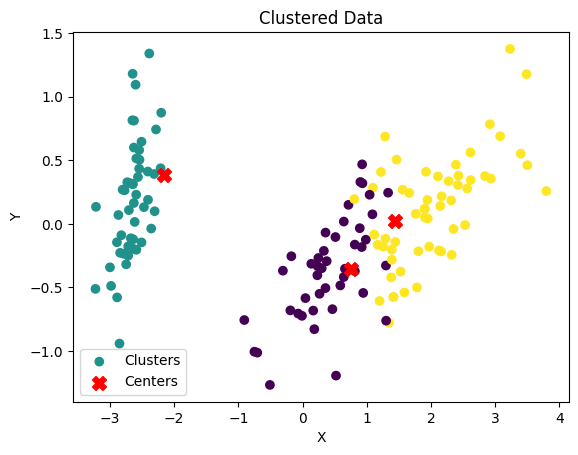

In [65]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

labels2 = cluster_indices

centers2 = centers_pca

df4_2 = pd.DataFrame({'x': main2[:, 0], 'y': main2[:, 1], 'labels in GA': labels2, 'Class': y2})
"""
fig = px.scatter(df4_2, x='x', y='y', color='labels in GA', hover_data=['Class'])
fig.update_traces(marker=dict(size=12))

# Centers of Clusters
fig.add_scatter(x=centers_pca[:, 0], y=centers_pca[:, 1], mode='markers', marker=dict( symbol='cross',size=10, color='black'))"""

plt.scatter(main2[:, 0], main2[:, 1], c=labels2, cmap='viridis', label='Clusters')

plt.scatter(centers2[:, 0], centers2[:, 1], marker='X', color='red', s=100, label='Centers')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clustered Data')
plt.legend()
plt.show()
# fig.show()

In [66]:
df4_2

,x,y,labels in GA,Class
0,-2.684126,0.319397,1,Setosa
1,-2.714142,-0.177001,1,Setosa
2,-2.888991,-0.144949,1,Setosa
3,-2.745343,-0.318299,1,Setosa
4,-2.728717,0.326755,1,Setosa
...,...,...,...,...
145,1.944110,0.187532,2,Virginica
146,1.527167,-0.375317,2,Virginica
147,1.764346,0.078859,2,Virginica
148,1.900942,0.116628,2,Virginica


In [67]:
dic = {}

GA_clusters = np.unique(cluster_indices)

for cluster_idx in GA_clusters:
    cluster_varieties = df4_2[df4_2['labels in GA'] == cluster_idx]['Class'].values
    cluster_varieties_count = np.unique(cluster_varieties, return_counts=True)
    cluster_variety = cluster_varieties_count[0][np.argmax(cluster_varieties_count[1])]
    dic[cluster_idx] = cluster_variety

dic

{0: 'Versicolor', 1: 'Setosa', 2: 'Virginica'}

In [68]:
df4_2['labels in GA'] = df4_2['labels in GA'].map(dic)
df4_2

,x,y,labels in GA,Class
0,-2.684126,0.319397,Setosa,Setosa
1,-2.714142,-0.177001,Setosa,Setosa
2,-2.888991,-0.144949,Setosa,Setosa
3,-2.745343,-0.318299,Setosa,Setosa
4,-2.728717,0.326755,Setosa,Setosa
...,...,...,...,...
145,1.944110,0.187532,Virginica,Virginica
146,1.527167,-0.375317,Virginica,Virginica
147,1.764346,0.078859,Virginica,Virginica
148,1.900942,0.116628,Virginica,Virginica


In [69]:
# calculate number of correct predictions
correct = 0
for i in range(len(df4_2)):
    if df4_2['labels in GA'][i] == df4_2['Class'][i]:
        correct += 1

In [70]:
print('accuracy: ', correct / len(df4_2))

accuracy:  0.9333333333333333


In [71]:
print('correct predictions: ', correct)
print('wrong predictions: ', len(df4_2) - correct)

correct predictions:  140
wrong predictions:  10


In [72]:
sc = 0
sw = 0
vc = 0
vw = 0
vi_c = 0
vi_w = 0

for i in range(len(df4_2)):
    if df4_2['Class'][i] == 'Setosa':
        if df4_2['labels in GA'][i] == 'Setosa':
            sc += 1
        else:
            sw += 1
    elif df4_2['Class'][i] == 'Versicolor':
        if df4_2['labels in GA'][i] == 'Versicolor':
            vc += 1
        else:
            vw += 1
    elif df4_2['Class'][i] == 'Virginica':
        if df4_2['labels in GA'][i] == 'Virginica':
            vi_c += 1
        else:
            vi_w += 1

In [73]:
print('Setosa correct: ', sc)
print('Setosa wrong: ', sw)
print('---------------------')
print('Versicolor correct: ', vc)
print('Versicolor wrong: ', vw)
print('----------------------')
print('Virginica correct: ', vi_c)
print('Virginica wrong: ', vi_w)

Setosa correct:  50
Setosa wrong:  0
---------------------
Versicolor correct:  42
Versicolor wrong:  8
----------------------
Virginica correct:  48
Virginica wrong:  2
